In [3]:
!pip install -f https://download.pytorch.org/whl/cu101/torch_stable.html torch==1.8.0+cu101 torchvision==0.9.0
!pip install wandb==0.12.1

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu101/torch-1.8.0%2Bcu101-cp37-cp37m-linux_x86_64.whl (763.5 MB)
  Using cached https://download.pytorch.org/whl/cu101/torchvision-0.9.0%2Bcu101-cp37-cp37m-linux_x86_64.whl (17.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0
    Uninstalling torch-1.12.0:
      Successfully uninstalled torch-1.12.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0
    Uninstalling torchvision-0.13.0:
      Successfully uninstalled torchvision-0.13.0


In [1]:
from tqdm import tqdm
from os import listdir
from random import *
seed(0)


import pandas as pd

from pylab import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cuda:2"

## Data trepanation

In [2]:
dataset = 'barents'
folder_train, folder_val, folder_test = dataset + '/train/maps/', dataset + '/valid/maps/', dataset + '/test/maps/'
train_files, val_files, test_files = sorted([file for file in listdir(folder_train)])[1346:],\
                                     sorted([file for file in listdir(folder_val)]),\
                                     sorted([file for file in listdir(folder_test)]) # + 1200

sample = torch.load(folder_train + train_files[1])
grid = torch.load(dataset + "/train/grid.pt")
coverage = pd.read_csv(dataset + "/train/coverage.csv")

len(train_files), len(val_files), len(test_files)

(1812, 366, 365)

In [3]:
keys = sample.keys()

In [4]:
def nan_check(tensor: torch.Tensor) -> bool:
    return True in tensor.isnan()

for key in keys:
    print(nan_check(sample[key]), key, sample[key].shape)

True cryosat.sic torch.Size([360, 500])
True cryosat.sit torch.Size([360, 500])
True jaxa.sic_asc torch.Size([360, 500])
True jaxa.sic_desc torch.Size([360, 500])
True jaxa.sic torch.Size([360, 500])
False gfs.f0d.temperature torch.Size([360, 500])
False gfs.f0d.pressure torch.Size([360, 500])
False gfs.f0d.wind_u torch.Size([360, 500])
False gfs.f0d.wind_v torch.Size([360, 500])
False gfs.f0d.wind torch.Size([360, 500])
False gfs.f1d.temperature torch.Size([360, 500])
False gfs.f1d.pressure torch.Size([360, 500])
False gfs.f1d.wind_u torch.Size([360, 500])
False gfs.f1d.wind_v torch.Size([360, 500])
False gfs.f1d.wind torch.Size([360, 500])
False gfs.f2d.temperature torch.Size([360, 500])
False gfs.f2d.pressure torch.Size([360, 500])
False gfs.f2d.wind_u torch.Size([360, 500])
False gfs.f2d.wind_v torch.Size([360, 500])
False gfs.f2d.wind torch.Size([360, 500])
False gfs.f3d.temperature torch.Size([360, 500])
False gfs.f3d.pressure torch.Size([360, 500])
False gfs.f3d.wind_u torch.Siz

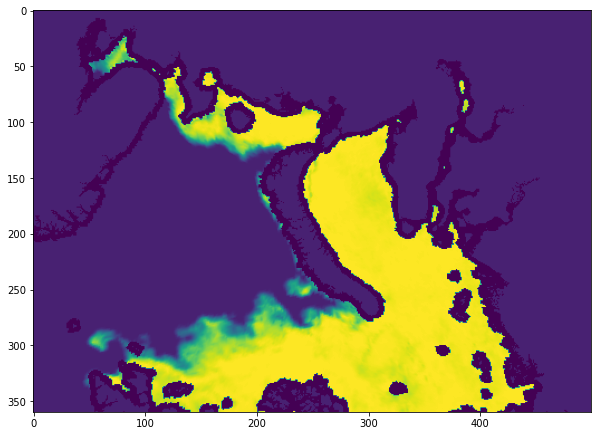

In [5]:
def preprocess_image(tensor: torch.Tensor) -> torch.Tensor:
    return (torch.nan_to_num(tensor, nan=-10.0) + grid['land']*10)

plt.figure(figsize=(10,10))
axs = imshow(preprocess_image(sample["jaxa.sic"]).reshape(360, 500).detach().cpu().numpy())

## Model trepanation

In [6]:
images_train = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(train_files)))]

images_val = [preprocess_image(torch.load(folder_val + val_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(val_files)))]

def handler(data: dict):
    try:
        return data["jaxa.sic"]
    except:
        return data["jaxa.sic_asc"]
    
images_test = [preprocess_image(handler(torch.load(folder_test + test_files[i])))\
                            for i in tqdm(range(0, len(test_files)))]

 24%|██▍       | 431/1812 [00:06<00:19, 70.71it/s]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/user/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_7501/2069040888.py", line 2, in <module>
    for i in tqdm(range(0, len(train_files)))]
  File "/tmp/ipykernel_7501/2069040888.py", line 2, in <listcomp>
    for i in tqdm(range(0, len(train_files)))]
  File "/home/jovyan/.imgenv-bert-large-0/lib/python3.7/site-packages/torch/serialization.py", line 592, in load
    return _load(opened_zipfile, map_location, pickle_module, **pickle_load_args)
  File "/home/jovyan/.imgenv-bert-large-0/lib/python3.7/site-packages/torch/serialization.py", line 851, in _load
    result = unpickler.load()
  File "/home/jovyan/.imgenv-bert-large-0/lib/python3.7/site-packages/torch/serialization.py", line 843, in persistent_load
    load_tensor(data_type, size, key, _maybe_decode_ascii(location))
  File "/home/jovyan/.imgenv-bert-large-0/li

TypeError: object of type 'NoneType' has no len()

In [ ]:
images_tensor_train, images_tensor_val, images_tensor_test = torch.stack(images_train).to(device),\
                                                             torch.stack(images_val).to(device),\
                                                             torch.stack(images_test).to(device)
images_tensor_train.shape

In [55]:
def average(data: list) -> float:
    return sum(data)/len(data)

def load_data(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)

def train(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    for epoch in range(1, epochs+1):
#        print("Current epoch", epoch)
        model.train()
        images_in, images_out = load_data(batch_size, images_tensor_train, d_in, d_out)
        optimizer.zero_grad()
        model_out = model(images_in)
        loss = criterion(model_out, images_out)
        loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % eval_step == 0:
            mae_total, rmse_total, mape_total = [], [], []
            
            total_test_len = len(images_tensor_test)
            start_point, steps = 0, int(total_test_len/(d_in + d_out))
            
            for i in range(steps):
                images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                        images_tensor_test[start_point+d_in:start_point+d_in+d_out]
                
                start_point += d_in + d_out
            
                model_out = model(images_in[None, :, :, :])
                
                criterion_mse = nn.MSELoss()
                
                loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
                loss_mae = criterion(model_out, images_out[None, :, :, :])
                
                mae_total.append(loss_mae.detach().cpu().numpy())
                rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                
            
            wandb.log(
                {
                 "test/test_MAE": average(mae_total), 
                 "test/test_RMSE": average(rmse_total)
                }
            )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [54]:
architecture = "UNet_default"
i = 0
wandb.init(project="SeaIcePrediction", entity="eighonet", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-07-24 15:10:14.801175: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [56]:
from models.unet.unet.unet_model import UNet

epochs = 1000
d_in, d_out = 7, 3
batch_size = 8
lr = 1e-3
eval_step = 20
criterion = nn.L1Loss()
model_a = UNet(7, 3).to(device)

train(model_a, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

Epoch  20 , test MAE -  12.035553826226128
Epoch  40 , test MAE -  11.641056484646267
Epoch  60 , test MAE -  11.30771213107639
Epoch  80 , test MAE -  11.037241617838541
Epoch  100 , test MAE -  10.864744398328993
Epoch  120 , test MAE -  10.708236694335938
Epoch  140 , test MAE -  10.546531677246094
Epoch  160 , test MAE -  10.378957960340712
Epoch  180 , test MAE -  10.214975992838541
Epoch  200 , test MAE -  10.031992594401041
Epoch  220 , test MAE -  9.869924757215712
Epoch  240 , test MAE -  9.698144700792101
Epoch  260 , test MAE -  9.531196594238281
Epoch  280 , test MAE -  9.329873826768663
Epoch  300 , test MAE -  9.15167490641276
Epoch  320 , test MAE -  8.956125895182291
Epoch  340 , test MAE -  8.773064507378471
Epoch  360 , test MAE -  8.569566514756945
Epoch  380 , test MAE -  8.382956610785591
Epoch  400 , test MAE -  8.162799411349827
Epoch  420 , test MAE -  7.9627634684244795
Epoch  440 , test MAE -  7.747506883409288
Epoch  460 , test MAE -  7.530576917860243
Epoch 

In [ ]:
train(model_a, criterion, d_in, d_out, 10000, batch_size, lr, eval_step)

## UNet GFS

In [7]:
gfs_keys = [item for item in sample.keys() if ('wind' in item and 'wind_' not in item) or 'temp' in item]

def handler(data: dict):
    try:
        return data["jaxa.sic"]
    except:
        return data["jaxa.sic_asc"]
    
def preprocess_image_gfs(tensor: torch.Tensor) -> torch.Tensor:
    layers = []
    
    for i in range(len(gfs_keys)):
        if gfs_keys[i] not in tensor.keys():
            tk = tensor.keys()
            print("Alarm")
            for key in tk:
                if key[-3:] == gfs_keys[i][-3:]:
                    layers.append(tensor[key])
                    break
        else:
            layers.append(tensor[gfs_keys[i]])
            
    sic_processed = torch.nan_to_num(handler(tensor), nan=-10.0) + grid['land']*10
    layers.append(sic_processed)
    
    return torch.stack(layers)
    
images_test_gfs = [preprocess_image_gfs(torch.load(folder_test + test_files[i]))\
                            for i in tqdm(range(0, len(test_files)))]

images_train_gfs = [preprocess_image_gfs(torch.load(folder_train + train_files[i]))\
                            for i in tqdm(range(0, len(train_files)))]

images_val_gfs = [preprocess_image_gfs(torch.load(folder_val + val_files[i]))\
                            for i in tqdm(range(0, len(val_files)))]

def average(data: list) -> float:
    return sum(data)/len(data)

def load_data_gfs(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        sic = images_tensor[start_point:start_point+d_in][:, -1, :, :]
        weather = images_tensor[start_point+d_in][:-1, :, :]
        in_batch.append(torch.cat((sic, weather), dim=0))
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out][:, -1, :, :])
    return torch.stack(in_batch), torch.stack(out_batch)

def train_gfs(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step, normalize):
    optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    for epoch in range(1, epochs+1):
#        print("Current epoch", epoch)
        model.train()
        images_in, images_out = load_data_gfs(batch_size, images_tensor_train_gfs, d_in, d_out)
        optimizer.zero_grad()
        model_out = model(images_in)
        loss = criterion(model_out, images_out)
        loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % eval_step == 0:
            mae_total, rmse_total, mape_total = [], [], []
            
            total_test_len = len(images_tensor_test_gfs)
            start_point, steps = 0, int(total_test_len/(d_in + d_out))
            
            for i in range(steps):
                sic = images_tensor_test_gfs[start_point:start_point+d_in][:, -1, :, :]
                weather = images_tensor_test_gfs[start_point+d_in][:-1, :, :]
                images_in = torch.cat((sic, weather), dim=0)
                
                images_out = images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out][:, -1, :, :]
                
                start_point += d_in + d_out
            
                model_out = model(images_in[None, :, :, :])
                
                criterion_mse = nn.MSELoss()
                
                loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
                loss_mae = criterion(model_out, images_out[None, :, :, :])
                
                mae_total.append(loss_mae.detach().cpu().numpy())
                rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                
            
            wandb.log(
                {
                 "test/test_MAE": average(mae_total), 
                 "test/test_RMSE": average(rmse_total)
                }
            )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

['gfs.f0d.temperature',
 'gfs.f0d.wind',
 'gfs.f1d.temperature',
 'gfs.f1d.wind',
 'gfs.f2d.temperature',
 'gfs.f2d.wind',
 'gfs.f3d.temperature',
 'gfs.f3d.wind']

In [9]:
images_tensor_train_gfs, images_tensor_val_gfs, images_tensor_test_gfs = torch.stack(images_train_gfs).to(device),\
                                                             torch.stack(images_val_gfs).to(device),\
                                                             torch.stack(images_test_gfs).to(device)
images_tensor_train_gfs.shape

torch.Size([1812, 9, 360, 500])

In [35]:
architecture = "ResNet_GFS_norm_7:3"
i = 0
wandb.init(project="SeaIcePrediction", entity="eighonet", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-07-26 14:27:08.250661: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [21]:
def average(data: list) -> float:
    return sum(data)/len(data)

def load_data_gfs(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        sic = images_tensor[start_point:start_point+d_in][:, -1, :, :]
        weather = images_tensor[start_point+d_in][:-1, :, :]
        in_batch.append(torch.cat((sic, weather), dim=0))
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out][:, -1, :, :])
    return torch.stack(in_batch), torch.stack(out_batch)

def train_gfs(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step, normalize):
    optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    for epoch in range(1, epochs+1):
#        print("Current epoch", epoch)
        model.train()
        images_in, images_out = load_data_gfs(batch_size, images_tensor_train_gfs, d_in, d_out)
        optimizer.zero_grad()
        model_out = model(images_in)
        loss = criterion(model_out, images_out)
        loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % eval_step == 0:
            mae_total, rmse_total, mape_total = [], [], []
            
            total_test_len = len(images_tensor_test_gfs)
            start_point, steps = 0, int(total_test_len/(d_in + d_out))
            
            for i in range(steps):
                sic = images_tensor_test_gfs[start_point:start_point+d_in][:, -1, :, :]
                weather = images_tensor_test_gfs[start_point+d_in][:-1, :, :]
                images_in = torch.cat((sic, weather), dim=0)
                
                images_out = images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out][:, -1, :, :]
                
                start_point += d_in + d_out
            
                model_out = model(images_in[None, :, :, :])
                
                criterion_mse = nn.MSELoss()
                
                loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
                loss_mae = criterion(model_out, images_out[None, :, :, :])
                
                mae_total.append(loss_mae.detach().cpu().numpy())
                rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                
            
            wandb.log(
                {
                 "test/test_MAE": average(mae_total), 
                 "test/test_RMSE": average(rmse_total)
                }
            )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [36]:
from torchvision import datasets, transforms, models

model = models.resnet152(pretrained=True)
model.conv1 = nn.Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = torch.nn.Sequential(*(list(model.children())[:-2])).to(device)
test_input = torch.zeros(4, 15, 360, 500).to(device)
model.requires_grad = False

 24%|██▍       | 431/1812 [26:30<1:24:56,  3.69s/it]


In [37]:
resnet152_aug = nn.Sequential(
    model,
    nn.ConvTranspose2d(2048, 2048 // 2, kernel_size=2, stride=(2,2)),
    nn.Conv2d(1024, 1024, kernel_size=3, padding=1, bias=False),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(1024, 1024 // 2, kernel_size=3, stride=(3,3)),
    nn.Conv2d(512, 511, kernel_size=3, padding=1, bias=False),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(511, 511 // 170, kernel_size=(5, 25), stride=(5,5)).to(device)
).to(device)

In [38]:
resnet152_aug(test_input).shape

torch.Size([4, 3, 360, 500])

In [39]:
from models.unet.unet.unet_model import UNet

epochs = 1000
d_in, d_out = 7, 3
batch_size = 4
lr = 1e-2
eval_step = 20
normalize = True
criterion = nn.L1Loss()

train_gfs(resnet152_aug, criterion, d_in, d_out, epochs, batch_size, lr, eval_step, normalize)

Epoch  20 , test MAE -  12.679046630859375
Epoch  40 , test MAE -  12.675715976291233
Epoch  60 , test MAE -  12.67522939046224
Epoch  80 , test MAE -  12.675582038031685
Epoch  100 , test MAE -  12.6759033203125
Epoch  120 , test MAE -  12.676169501410591
Epoch  140 , test MAE -  12.676162719726562
Epoch  160 , test MAE -  12.675980461968315
Epoch  180 , test MAE -  12.675755818684896
Epoch  200 , test MAE -  12.675008985731337
Epoch  220 , test MAE -  12.67677476671007
Epoch  240 , test MAE -  12.675230238172743
Epoch  260 , test MAE -  12.675909254286024
Epoch  280 , test MAE -  12.676158481174046
Epoch  300 , test MAE -  12.675803290473091
Epoch  320 , test MAE -  12.675183614095053
Epoch  340 , test MAE -  12.676077948676216
Epoch  360 , test MAE -  12.675514221191406
Epoch  380 , test MAE -  12.67553965250651
Epoch  400 , test MAE -  12.67580837673611
Epoch  420 , test MAE -  12.676561991373697
Epoch  440 , test MAE -  12.675667656792534
Epoch  460 , test MAE -  12.67556169297960

In [22]:

train_gfs(model_a, criterion, d_in, d_out, 10000, batch_size, 1e-4, eval_step, normalize)

Epoch  20 , test MAE -  3.4241434733072915
Epoch  40 , test MAE -  3.3105385189964656
Epoch  60 , test MAE -  3.269223894391741
Epoch  80 , test MAE -  3.298082260858445
Epoch  100 , test MAE -  3.2904979160853793
Epoch  120 , test MAE -  3.2988150460379466
Epoch  140 , test MAE -  3.2811373756045388
Epoch  160 , test MAE -  3.298552013578869
Epoch  180 , test MAE -  3.261724199567522
Epoch  200 , test MAE -  3.278741019112723
Epoch  220 , test MAE -  3.2482288905552457
Epoch  240 , test MAE -  3.2307855515252974
Epoch  260 , test MAE -  3.221403576078869
Epoch  280 , test MAE -  3.223626273018973
Epoch  300 , test MAE -  3.2191158476329984
Epoch  320 , test MAE -  3.240725562686012
Epoch  340 , test MAE -  3.235550290062314
Epoch  360 , test MAE -  3.2485852922712053
Epoch  380 , test MAE -  3.2310707455589656
Epoch  400 , test MAE -  3.245122637067522
Epoch  420 , test MAE -  3.1707225981212797
Epoch  440 , test MAE -  3.240866161528088
Epoch  460 , test MAE -  3.209023975190662
Epoc

Epoch  3740 , test MAE -  2.9698588053385415
Epoch  3760 , test MAE -  2.966842288062686
Epoch  3780 , test MAE -  3.079464867001488
Epoch  3800 , test MAE -  3.0292874290829612
Epoch  3820 , test MAE -  3.007363818940662
Epoch  3840 , test MAE -  3.0081160409109935
Epoch  3860 , test MAE -  2.989047640845889
Epoch  3880 , test MAE -  2.9744395301455544
Epoch  3900 , test MAE -  2.963897160121373
Epoch  3920 , test MAE -  2.9452064150855657
Epoch  3940 , test MAE -  2.9820048014322915
Epoch  3960 , test MAE -  2.95747557140532
Epoch  3980 , test MAE -  2.96041506812686
Epoch  4000 , test MAE -  2.939660208565848
Epoch  4020 , test MAE -  3.024381546747117
Epoch  4040 , test MAE -  2.975699470156715
Epoch  4060 , test MAE -  3.0969801403227306
Epoch  4080 , test MAE -  3.0389847528366816
Epoch  4100 , test MAE -  3.0398321605864025
Epoch  4120 , test MAE -  3.0034964425223216
Epoch  4140 , test MAE -  3.0417980012439547
Epoch  4160 , test MAE -  3.0202916463216147
Epoch  4180 , test MAE

Epoch  7940 , test MAE -  2.8234311058407737
Epoch  7960 , test MAE -  2.8505152747744607
Epoch  7980 , test MAE -  2.841742379324777
Epoch  8000 , test MAE -  2.915126618884859
Epoch  8020 , test MAE -  2.9108572460356212
Epoch  8040 , test MAE -  2.8437062218075706
Epoch  8060 , test MAE -  2.905321938650949
Epoch  8080 , test MAE -  2.8258634294782365
Epoch  8100 , test MAE -  2.9002205984933034
Epoch  8120 , test MAE -  2.9245089576357888
Epoch  8140 , test MAE -  2.8173375810895647
Epoch  8160 , test MAE -  2.8196937924339656
Epoch  8180 , test MAE -  2.81616701398577
Epoch  8200 , test MAE -  2.8312523251488093
Epoch  8220 , test MAE -  2.887904757545108
Epoch  8240 , test MAE -  2.832818349202474
Epoch  8260 , test MAE -  2.8539559500558034
Epoch  8280 , test MAE -  2.8288040161132812
Epoch  8300 , test MAE -  2.8792828151157925
Epoch  8320 , test MAE -  2.862781524658203
Epoch  8340 , test MAE -  2.876050494966053
Epoch  8360 , test MAE -  2.842795962379092
Epoch  8380 , test M

In [61]:
images_tensor_train_gfs_np = images_tensor_train_gfs.cpu().numpy()

In [62]:
data = images_tensor_train_gfs_np

In [70]:
import numpy as np

# data = np.random.normal(loc=0, scale=1, size=(96108, 7, 7))
data_min = np.min(data, axis=(1,2,3), keepdims=True)
data_max = np.max(data, axis=(1,2,3), keepdims=True)

scaled_data = (data - data_min) / (data_max - data_min)

In [ ]:
scaled_data*(data_max - data_min)

In [71]:
scaled_data.shape

(1812, 9, 360, 500)

In [72]:
scaled_data[0][0]

array([[0.9777034 , 0.9773288 , 0.9768093 , ..., 0.96315116, 0.96308655,
        0.9630696 ],
       [0.977667  , 0.9772811 , 0.97686255, ..., 0.96296054, 0.9629497 ,
        0.96293   ],
       [0.9776438 , 0.97724694, 0.97685874, ..., 0.96282965, 0.9628245 ,
        0.96276325],
       ...,
       [0.9847687 , 0.98451895, 0.98426574, ..., 0.92624736, 0.9258093 ,
        0.92527354],
       [0.98462695, 0.98437583, 0.9841222 , ..., 0.92687666, 0.92632633,
        0.92608243],
       [0.98448104, 0.98422205, 0.98397183, ..., 0.92726815, 0.927024  ,
        0.9266455 ]], dtype=float32)

In [73]:
scaled_data[0][-1]

array([[0.03487178, 0.03487178, 0.03487178, ..., 0.03487178, 0.03487178,
        0.03487178],
       [0.03487178, 0.03487178, 0.03487178, ..., 0.03487178, 0.03487178,
        0.03487178],
       [0.03487178, 0.03487178, 0.03487178, ..., 0.03487178, 0.03487178,
        0.03487178],
       ...,
       [0.03487178, 0.03487178, 0.03487178, ..., 0.03487178, 0.03487178,
        0.03487178],
       [0.03487178, 0.03487178, 0.03487178, ..., 0.03487178, 0.03487178,
        0.03487178],
       [0.03487178, 0.03487178, 0.03487178, ..., 0.03487178, 0.03487178,
        0.03487178]], dtype=float32)

In [75]:
images_tensor_train_gfs[0][0]

tensor([[270.3709, 270.2635, 270.1146,  ..., 266.1979, 266.1794, 266.1745],
        [270.3605, 270.2498, 270.1298,  ..., 266.1432, 266.1401, 266.1345],
        [270.3539, 270.2401, 270.1287,  ..., 266.1057, 266.1042, 266.0866],
        ...,
        [272.3970, 272.3254, 272.2528,  ..., 255.6152, 255.4896, 255.3359],
        [272.3564, 272.2844, 272.2116,  ..., 255.7956, 255.6378, 255.5679],
        [272.3145, 272.2403, 272.1685,  ..., 255.9079, 255.8379, 255.7293]],
       device='cuda:1')

In [46]:
t = torch.tensor([[1.,2.,3.],[4.,5.,6.]])
print("Tensor:", t)

Tensor: tensor([[1., 2., 3.],
        [4., 5., 6.]])


In [48]:
t1 = normalize(t, p=1.0, dim = 1)
t2 = normalize(t, p=2.0, dim = 0)

TypeError: 'bool' object is not callable

In [47]:
torch.unique(images_tensor_train_gfs[0][-1])

tensor([-1.0000e+01,  0.0000e+00,  3.1983e-05,  ...,  1.0000e+02,
         1.0000e+02,  1.0000e+02], device='cuda:1')

In [27]:
from torch.nn.functional import normalize


In [ ]:

normalize_layer = torch.nn.functional.normalize(input, p=2.0, dim=1, eps=1e-12, out=None)

### Prebuild

In [29]:
%load_ext autoreload
%autoreload 2

from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
model_3d = UNet3D(7, 3).to(device)
model_3d_r = ResidualUNet3D(7, 3).to(device)

In [16]:
init = images_tensor_train_gfs[:7][None, :, :, :, :]
out = F.pad(init, (0, 0, 0, 0, 2, 2), "constant", 0)
init.shape, out.shape

(torch.Size([1, 7, 6, 360, 500]), torch.Size([1, 7, 10, 360, 500]))

In [34]:
criterion = nn.MSELoss()

In [35]:
criterion(model_3d(out).squeeze(), images_tensor_test[0+7:0+7+3])

It works!


tensor(863.4682, device='cuda:0', grad_fn=<MseLossBackward>)

In [30]:
model_3d(out).squeeze().shape

It works!


torch.Size([3, 360, 500])

In [21]:
load_data(2, images_tensor_train_gfs, 7, 3)[1].shape

torch.Size([2, 3, 6, 360, 500])

In [28]:
images_tensor_test_gfs[0:0+7][None, :, :, :, :].shape, images_tensor_test_gfs[0+7:0+7+3].shape

(torch.Size([1, 7, 6, 360, 500]), torch.Size([3, 6, 360, 500]))

In [26]:
images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out].shape

NameError: name 'start_point' is not defined

In [10]:
def load_data_3d(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)


def train_3d(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    for epoch in range(1, epochs+1):
        print("Current epoch", epoch)
        model.train()
        images_in, images_out = load_data_3d(batch_size, images_tensor_train_gfs, d_in, d_out)
        optimizer.zero_grad()
        images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
        model_out = model(images_in_padded)
        loss = criterion(model_out, images_out[:, :, -1, :, :])
        loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % eval_step == 0:
            mae_total, rmse_total, mape_total = [], [], []
            
            total_test_len = len(images_tensor_test_gfs)
            start_point, steps = 0, int(total_test_len/(d_in + d_out))
            
            for i in tqdm(range(steps)):
                images_in, images_out = images_tensor_test_gfs[start_point:start_point+d_in],\
                                        images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out][:, -1, :, :]
                
                start_point += d_in + d_out
                
                images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
                model_out = model(images_in_padded[None, :, :, :, :]).squeeze()
                
                criterion_mse = nn.MSELoss()
                
                loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
                loss_mae = criterion(model_out, images_out[None, :, :, :])
                
                mae_total.append(loss_mae.detach().cpu().numpy())
                rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                del images_in, images_out, model_out
                gc.collect()
                torch.cuda.empty_cache()
            
            wandb.log(
                {
                 "test/test_MAE": average(mae_total), 
                 "test/test_RMSE": average(rmse_total)
                }
            )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [11]:
architecture = "UNet3D_default"
i = 0
wandb.init(project="SeaIcePrediction", entity="eighonet", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

wandb: Currently logged in as: sbercv (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-07-24 11:31:50.786818: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [14]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [15]:
%load_ext autoreload
%autoreload 2
from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

epochs = 100
d_in, d_out = 7, 3
batch_size = 1
lr = 1e-3
eval_step = 10
criterion = nn.L1Loss()
model_3d = UNet3D(7, 3).to(device)

train_3d(model_3d, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current epoch 1


RuntimeError: CUDA out of memory. Tried to allocate 1.03 GiB (GPU 0; 31.72 GiB total capacity; 29.64 GiB already allocated; 746.44 MiB free; 29.67 GiB reserved in total by PyTorch)

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Cl

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Cl

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Cl

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Cl

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Cl

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Cl

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/eighonet/SeaIcePrediction/1t5cu1nc/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Cl

In [1]:
UNet3D(7, 3)

NameError: name 'UNet3D' is not defined

### Manual

In [41]:
out_channels = 3
test_conv3d = nn.Conv3d(7, 1, kernel_size=3, padding=1, bias=False).to(device)
test_conv2d = nn.Conv2d(6, out_channels, kernel_size=3, padding=1, bias=False).to(device)

In [42]:
test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1).shape
result_prj = test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1)
test_conv2d(result_prj).shape

torch.Size([1, 3, 360, 500])

In [39]:
images_tensor_train_gfs[:7][None, :, :, :, :].shape

torch.Size([1, 7, 6, 360, 500])

In [40]:
result_prj.shape

torch.Size([1, 6, 360, 500])

In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
%load_ext autoreload
%autoreload 2

from models.unet.unet.unet_model_3d import UNet_3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
model_3d = UNet_3d(7, 3).to(device)

In [17]:
torch.zeros([1, 256, 1, 90, 125]).squeeze(2).shape

torch.Size([1, 256, 90, 125])

In [18]:
model_3d

UNet_3d(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(7, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 

In [19]:
model_3d(images_tensor_train_gfs[:7][None, :, :, :, :])

torch.Size([1, 128, 3, 180, 250])
torch.Size([1, 256, 90, 125])
torch.Size([1, 512, 45, 62])
torch.Size([1, 1024, 22, 31])


RuntimeError: Tensors must have same number of dimensions: got 4 and 5

In [20]:
%debug

> /home/jovyan/Ice/models/unet/unet/unet_parts_3d.py(99)forward()
     97         # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
     98         # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
---> 99         x = torch.cat([x2, x1], dim=1)
    100         return self.conv(x)
    101 

ipdb> x2.shape
torch.Size([1, 128, 3, 180, 250])
ipdb> x1.shape
torch.Size([1, 128, 3, 180])
ipdb> exit
